<a href="https://colab.research.google.com/github/justell6/awesome-R/blob/master/flash_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install NeqSim python package
For learning of how to use NeqSim see the [NeqSim github page](https://equinor.github.io/neqsimhome/).

In [ ]:
%%capture
!pip install neqsim

# Phase diagram for methane - n-heptane for a specified binary interaction parameter
This code cell generates the data for the phase diagram plots. It loops through different temperature and pressure values, performs a flash calculation using NeqSim for each point, and stores the resulting phase type information in a 2D array called data. The line separating pure oil and pure gas could be hidden (as density changes continously). NeqSim definition of oil is v/b < 1.75.

time per flash  0.6028827905654907  msec


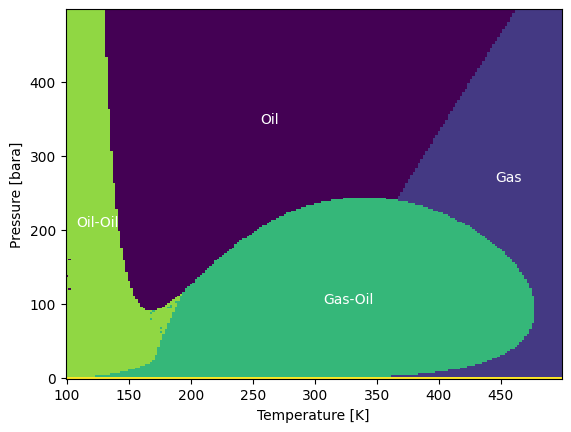

In [ ]:
from neqsim import jneqsim
from neqsim.thermo import TPflash
import time
import numpy as np
kij = 0.05

x_y_points = 200

testSystem = jneqsim.thermo.system.SystemPrEos(); # other models can be selected from: https://github.com/equinor/neqsim/tree/master/src/main/java/neqsim/thermo/system
testSystem.addComponent("methane", 70.0);
testSystem.addComponent("n-heptane", 30.0);

testSystem.setMixingRule("classic");

testSystem.getPhase(0).getMixingRule().setBinaryInteractionParameter(0, 1, kij)
testSystem.getPhase(1).getMixingRule().setBinaryInteractionParameter(0, 1, kij)

testSystem.setMultiPhaseCheck(True);

data = np.zeros([x_y_points, x_y_points], dtype=np.uint8)
density_data = np.zeros([x_y_points, x_y_points])
pressures = []
temperatures = []

start = time.time()

for i in range(data.shape[0]):
  pres = i * 2.5
  testSystem.setPressure(pres, "bara")
  pressures.append(pres)
  if i == 0:
    for j in range(data.shape[1]):
        temp = 100 + j*2.0
        temperatures.append(temp)

  for j in range(data.shape[1]):
    testSystem.setTemperature(temperatures[j], "K")

    try:
      TPflash(testSystem)
      data[i][j] = testSystem.getNumberOfPhases()
      testSystem.initPhysicalProperties('density')
      density_data[i][j] = testSystem.getDensity('kg/m3')

      if(testSystem.hasPhaseType('aqueous') and testSystem.hasPhaseType('oil') and not testSystem.hasPhaseType('gas')):
        data[i][j] = 4
      if(not testSystem.hasPhaseType('aqueous') and testSystem.hasPhaseType('oil') and not testSystem.hasPhaseType('gas')):
        data[i][j] = 5
      if(not testSystem.hasPhaseType('aqueous') and not testSystem.hasPhaseType('oil') and testSystem.hasPhaseType('gas')):
        data[i][j] = 6
      if(testSystem.hasPhaseType('aqueous') and testSystem.hasPhaseType('oil') and testSystem.hasPhaseType('gas')):
        data[i][j] = 7
      if(testSystem.hasPhaseType('aqueous') and not testSystem.hasPhaseType('oil') and testSystem.hasPhaseType('gas')):
        data[i][j] = 8
      if(not testSystem.hasPhaseType('aqueous') and testSystem.hasPhaseType('oil') and testSystem.hasPhaseType('gas')):
        data[i][j] = 9
      if testSystem.hasPhaseType('oil') and testSystem.getNumberOfPhases() == 2 and not testSystem.hasPhaseType('gas') and not testSystem.hasPhaseType('aqueous'):
            data[i][j] = 10
    except:
       data[i][j] = 11

end  = time.time()
time = end-start

print('time per flash ', time/(x_y_points*x_y_points)*1000, ' msec')


import matplotlib.pyplot as plt
import numpy as np

# Assuming the data array and other variables are already populated

# Define a dictionary to map data values to region names
region_labels = {
    4: 'Aqueous-Oil',
    5: 'Oil',
    6: 'Gas',
    7: 'Gas-Oil-Aqueous',
    8: 'Gas-Aqueous',
    9: 'Gas-Oil',
    10: 'Oil-Oil'
}

# Dictionary to store the coordinates of all points in each region
region_points = {key: [] for key in region_labels.keys()}

# Collect all points for each region
for i in range(x_y_points):
    for j in range(x_y_points):
        region_value = data[i][j]
        if region_value in region_points:
            region_points[region_value].append((temperatures[j], pressures[i]))

# Plot the data
plt.pcolormesh(temperatures, pressures, data, cmap='viridis')
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [bara]')

# Add one label at the center of each region
for region_value, points in region_points.items():
    if points:
        # Calculate the centroid of the region
        avg_temp = np.mean([p[0] for p in points])
        avg_pres = np.mean([p[1] for p in points])
        # Place the label at the centroid
        plt.text(avg_temp, avg_pres, region_labels[region_value], fontsize=10, ha='center', va='center', color='white')

plt.show()


# Illustration of mixture density in phase diagram
This following figure displays a combined view of the mixture density and phase types as a function of temperature and pressure. The color gradient represents the mixture density, transitioning from green (low density) to blue (high density). The red contour lines indicate the boundaries between different phase regions, which are labeled with text directly on the plot (e.g., "Oil", "Gas", "Gas-Oil"). This visualization helps in understanding how both density and phase behavior change across the temperature-pressure space. The line separating pure oil and pure gas could be hidden (as density changes continously). NeqSim definition of oil is v/b < 1.75.

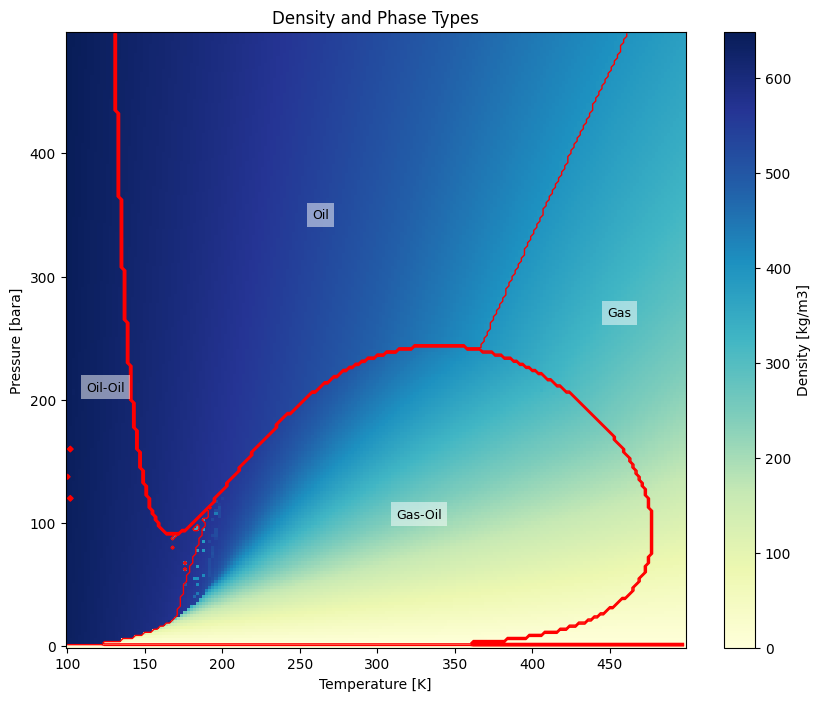

In [ ]:
# --- 2. PLOTTING ---

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the density data as a colormap
im = ax.pcolormesh(temperatures, pressures, density_data, cmap='YlGnBu', shading='auto')
fig.colorbar(im, ax=ax, label='Density [kg/m3]')

# Overlay phase boundaries using contours on the phase data array
contour_levels = [3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]
contour = ax.contour(temperatures, pressures, data, levels=contour_levels, colors='red', linewidths=1)

# Add labels to the axes
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [bara]')
ax.set_title('Density and Phase Types')

# Define a dictionary to map data values to region names
region_labels = {
    4: 'Aqueous-Oil',
    5: 'Oil',
    6: 'Gas',
    7: 'Gas-Oil-Aqueous',
    8: 'Gas-Aqueous',
    9: 'Gas-Oil',
    10: 'Oil-Oil'
}

# Dictionary to store the coordinates of all points in each region
region_points = {key: [] for key in region_labels.keys()}

# Collect all points for each region from the phase data
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        region_value = data[i][j]
        if region_value in region_points:
            region_points[region_value].append((temperatures[j], pressures[i]))

# Add one label at the center of each region
for region_value, points in region_points.items():
    if points:
        # Calculate the centroid of the region
        avg_temp = np.mean([p[0] for p in points])
        avg_pres = np.mean([p[1] for p in points])
        # Place the label at the centroid
        ax.text(avg_temp, avg_pres, region_labels[region_value], fontsize=9, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.show()

# Task
Create an animation showing how the phase diagram plot changes as the `kij` value varies from -0.1 to 0.1.

## Generate data for multiple kij values

### Subtask:
Modify the existing code to loop through different `kij` values from -0,1 to 0.1 and generate the `data` array for each `kij`.


**Reasoning**:
The subtask requires modifying the existing code to generate data for different kij values. This involves creating a loop for kij, setting the kij in the system, and storing the generated data in a list.



In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from neqsim import jneqsim
from neqsim.thermo import TPflash

# Create a list to store the data arrays for animation
all_data = []
# Create a list of kij values
kij_values = np.linspace(-0.1, 0.1, 20) # Using 20 steps from -0.1 to 0.1

x_y_points = 200

for kij in kij_values:
    testSystem = jneqsim.thermo.system.SystemPrEos();
    testSystem.addComponent("methane", 70.0);
    testSystem.addComponent("n-heptane", 30.0);

    testSystem.setMixingRule("classic");

    testSystem.getPhase(0).getMixingRule().setBinaryInteractionParameter(0, 1, kij)
    testSystem.getPhase(1).getMixingRule().setBinaryInteractionParameter(0, 1, kij)

    testSystem.setMultiPhaseCheck(True);

    data = np.zeros([x_y_points,x_y_points],dtype=np.uint8)
    pressures = []
    temperatures = []

    start = time.time()

    for i in range(data.shape[0]):
      pres = i*2.5
      testSystem.setPressure(pres, "bara")
      pressures.append(pres)


      for j in range(data.shape[1]):
        temp = 200 + j*1.5
        testSystem.setTemperature(temp, "K")
        if i == 0: # Only need to append temperatures once per kij
            temperatures.append(testSystem.getTemperature('K'))
        try:
          TPflash(testSystem)
          data[i][j] = testSystem.getNumberOfPhases()
          if(testSystem.hasPhaseType('aqueous') and testSystem.hasPhaseType('oil') and not testSystem.hasPhaseType('gas')):
            data[i][j] = 4
          if(not testSystem.hasPhaseType('aqueous') and testSystem.hasPhaseType('oil') and not testSystem.hasPhaseType('gas')):
            data[i][j] = 5
          if(not testSystem.hasPhaseType('aqueous') and not testSystem.hasPhaseType('oil') and testSystem.hasPhaseType('gas')):
            data[i][j] = 6
          if(testSystem.hasPhaseType('aqueous') and testSystem.hasPhaseType('oil') and testSystem.hasPhaseType('gas')):
            data[i][j] = 7
          if(testSystem.hasPhaseType('aqueous') and not testSystem.hasPhaseType('oil') and testSystem.hasPhaseType('gas')):
            data[i][j] = 8
          if(not testSystem.hasPhaseType('aqueous') and testSystem.hasPhaseType('oil') and testSystem.hasPhaseType('gas')):
            data[i][j] = 9
          if testSystem.hasPhaseType('oil') and testSystem.getNumberOfPhases() == 2 and not testSystem.hasPhaseType('gas') and not testSystem.hasPhaseType('aqueous'):
                data[i][j] = 10
        except:
          data[i][j] = 11

    end  = time.time()
    time_taken = end-start

    print(f'time per flash for kij={kij}: {time_taken/(x_y_points*x_y_points)*1000:.3f} msec')

    all_data.append(data)

# The all_data list now contains the phase diagrams for each kij value.
# pressures and temperatures lists will be from the last iteration, which is fine for plotting

time per flash for kij=-0.1: 0.353 msec
time per flash for kij=-0.08947368421052632: 0.348 msec
time per flash for kij=-0.07894736842105264: 0.373 msec
time per flash for kij=-0.06842105263157895: 0.390 msec
time per flash for kij=-0.05789473684210527: 0.360 msec
time per flash for kij=-0.04736842105263159: 0.384 msec
time per flash for kij=-0.0368421052631579: 0.427 msec
time per flash for kij=-0.026315789473684223: 0.401 msec
time per flash for kij=-0.015789473684210534: 0.402 msec
time per flash for kij=-0.005263157894736845: 0.427 msec
time per flash for kij=0.005263157894736831: 0.442 msec
time per flash for kij=0.01578947368421052: 0.429 msec
time per flash for kij=0.02631578947368421: 0.444 msec
time per flash for kij=0.0368421052631579: 0.456 msec
time per flash for kij=0.04736842105263156: 0.482 msec
time per flash for kij=0.05789473684210525: 0.495 msec
time per flash for kij=0.06842105263157894: 0.476 msec
time per flash for kij=0.07894736842105263: 0.475 msec
time per flash

## Store data for animation

### Subtask:
Store the generated `data` arrays and corresponding `kij` values in a list or array.


## Create animation

### Subtask:
Use the stored data to create an animation of the phase diagram changing with `kij`. This will likely involve using `matplotlib.animation`.


**Reasoning**:
Create an animation of the phase diagram using the stored data and matplotlib.animation.



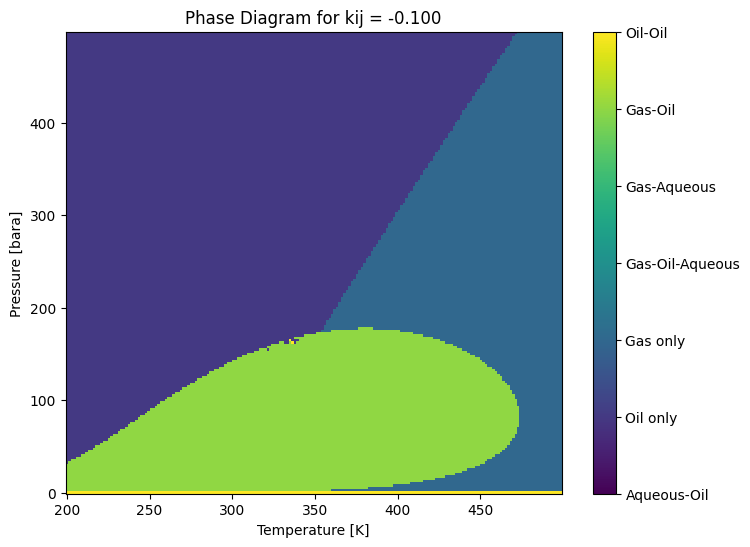

In [ ]:
from matplotlib.animation import FuncAnimation

# Define a dictionary to map data values to region names
region_labels = {
    4: 'Aqueous-Oil',
    5: 'Oil',
    6: 'Gas',
    7: 'Gas-Oil-Aqueous',
    8: 'Gas-Aqueous',
    9: 'Gas-Oil',
    10: 'Oil-Oil'
}

fig, ax = plt.subplots(figsize=(8, 6))

# Initialize the plot with the first data set
cax = ax.pcolormesh(temperatures, pressures, all_data[0], cmap='viridis', vmin=4, vmax=10) # Set vmin and vmax based on region_labels

# Add labels to the axes
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [bara]')

# Add a colorbar
cbar = fig.colorbar(cax, ax=ax, ticks=list(region_labels.keys()))
cbar.ax.set_yticklabels(list(region_labels.values()))


def update(frame):
    """Updates the plot for each frame of the animation."""
    cax.set_array(all_data[frame].ravel()) # Use ravel() to flatten the data
    ax.set_title(f'Phase Diagram for kij = {kij_values[frame]:.3f}')
    return cax, # Return the updated artist as a tuple

# Create the animation
ani = FuncAnimation(fig, update, frames=len(all_data), interval=500, blit=True)

# To display the animation in the notebook, you might need to save it first
# ani.save('phase_diagram_animation.gif', writer='imagemagick')

plt.show()

## Display animation

### Subtask:
Display the generated animation.


**Reasoning**:
Display the created animation object within the notebook environment.



In [ ]:
from IPython.display import HTML

# Display the animation
HTML(ani.to_jshtml())

In [ ]:
ani.save('phase_diagram_animation.gif', writer='Pillow')